In [2]:
import pandas as pd
import pylab
import scipy.stats as stats
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)


In [4]:
df = pd.read_csv('gestures_v2.csv')
df.head()

,time,gfc_x,gfc_y,gfc_z,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,inc_x,inc_y,inc_z,label
0,2023-06-08 16:44:55.950,0.014940,0.020080,0.976280,-0.001680,-0.002160,-0.095120,0.046710,-0.006570,-0.234180,141.708,63.084000,-20.4480,174.234850,-0.652350,0.501900,rest
1,2023-06-08 16:44:56.100,0.020082,0.014773,0.980182,0.006200,-0.031082,-0.206045,0.006595,-0.001950,-0.032759,185.340,83.839091,-32.2500,300.827559,-1.049591,1.106823,rest
2,2023-06-08 16:44:56.250,0.011158,0.027933,0.995408,-0.037542,0.034142,-0.057250,0.006312,0.007354,-0.002104,185.975,82.922500,-32.1125,294.368688,-1.397988,0.908512,rest
3,2023-06-08 16:44:56.400,0.016180,0.022590,0.995210,0.003410,-0.040190,-0.044340,-0.009860,-0.007945,-0.004920,179.964,79.404000,-27.4560,294.300950,-1.534310,0.810780,rest
4,2023-06-08 16:44:56.550,0.022350,0.009575,0.988850,0.061683,-0.123242,-0.106292,0.001287,0.003938,-0.002892,175.780,77.375000,-23.3800,294.201417,-1.261021,0.963921,rest


In [8]:
# Assuming you want to perform Fourier transformation on the 'acc_x' column
transformed_data = np.fft.fft(df['acc_x'])
frequencies = np.fft.fftfreq(len(df['acc_x']))

In [9]:
# Assuming you want to extract frequencies between 0.1 Hz and 1 Hz
min_frequency = 0.1
max_frequency = 1.0

# Find the indices of frequencies within the specified range
indices = np.where((frequencies >= min_frequency) & (frequencies <= max_frequency))

# Extract the corresponding frequencies and transformed data
extracted_frequencies = frequencies[indices]
extracted_data = transformed_data[indices]


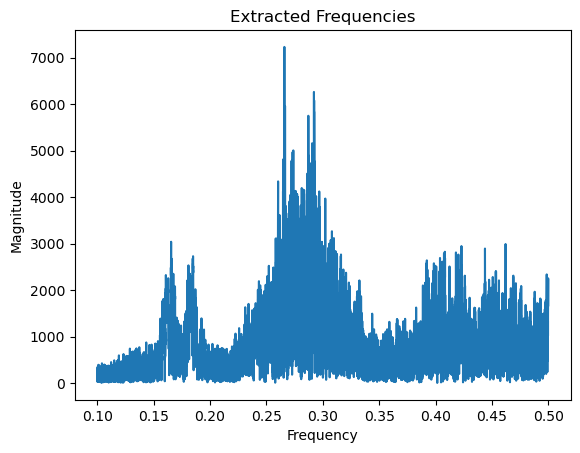

In [10]:
magnitude_spectrum = np.abs(extracted_data)
plt.plot(extracted_frequencies, magnitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Extracted Frequencies')
plt.show()


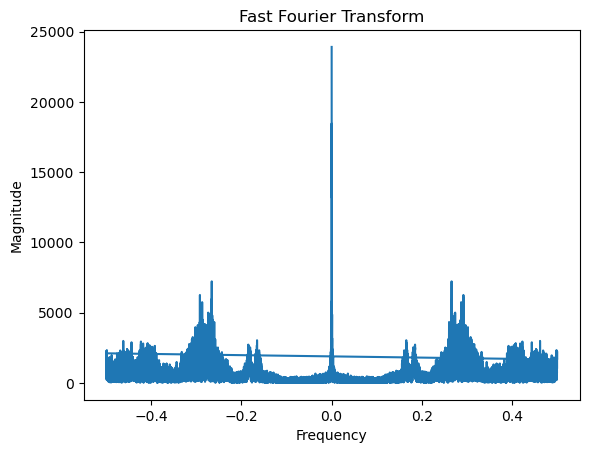

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('gestures_v2.csv')

# Select the column you want to apply FFT to
column_name = 'acc_x'
data = df[column_name]

# Apply FFT to the selected column
transformed_data = np.fft.fft(data)

# Compute the corresponding frequencies
sample_rate = 1  # Assuming the data is sampled at a rate of 1 sample per unit time
frequencies = np.fft.fftfreq(len(data), d=1/sample_rate)

# Plot the magnitude spectrum
magnitude_spectrum = np.abs(transformed_data)
plt.plot(frequencies, magnitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Fast Fourier Transform')
plt.show()


In [3]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 4                                               #
#                                                            #
##############################################################

import numpy as np
import pandas as pd

# This class performs a Fourier transformation on the data to find frequencies that occur
# often and filter noise.
class FourierTransformation:
    
    def __init__(self):
        self.temp_list = []
        self.freqs = None

    # Find the amplitudes of the different frequencies using a fast fourier transformation. Here,
    # the sampling rate expresses
    # the number of samples per second (i.e. Frequency is Hertz of the dataset).
    
    def find_fft_transformation(self, data):
        # Create the transformation, this includes the amplitudes of both the real
        # and imaginary part.
        # print(data.shape)
        transformation = np.fft.rfft(data, len(data))
        # real
        real_ampl = transformation.real
        # max
        max_freq = self.freqs[np.argmax(real_ampl[0:len(real_ampl)])]
        # weigthed
        freq_weigthed = float(np.sum(self.freqs * real_ampl)) / np.sum(real_ampl)

        # pse

        PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
        PSD_pdf = np.divide(PSD, np.sum(PSD))

        # Make sure there are no zeros.
        if np.count_nonzero(PSD_pdf) == PSD_pdf.size:
            pse = -np.sum(np.log(PSD_pdf) * PSD_pdf)
        else:
            pse = 0

        real_ampl = np.insert(real_ampl, 0, max_freq)
        real_ampl = np.insert(real_ampl, 0, freq_weigthed)
        row = np.insert(real_ampl, 0, pse)

        self.temp_list.append(row)

        return 0

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, columns, window_size, sampling_rate):
        self.freqs = (sampling_rate * np.fft.rfftfreq(int(window_size))).round(3)

        for col in columns:
            collist = []
            # prepare column names
            collist.append(col + '_max_freq')
            collist.append(col + '_freq_weighted')
            collist.append(col + '_pse')
            
            collist = collist + [col + '_freq_' +
                    str(freq) + '_Hz_ws_' + str(window_size) for freq in self.freqs]
           
            # rolling statistics to calculate frequencies, per window size. 
            # Pandas Rolling method can only return one aggregation value. 
            # Therefore values are not returned but stored in temp class variable 'temp_list'.

            # note to self! Rolling window_size would be nicer and more logical! In older version windowsize is actually 41. (ws + 1)
            data_table[col].rolling(
                window_size + 1).apply(self.find_fft_transformation)

            # Pad the missing rows with nans
            frequencies = np.pad(np.array(self.temp_list), ((window_size, 0), (0, 0)),
                        'constant', constant_values=np.nan)
            # add new freq columns to frame
            
            data_table[collist] = pd.DataFrame(frequencies, index=data_table.index)

            # reset temp-storage array
            del self.temp_list[:]
            

        
        return data_table


In [4]:

import matplotlib.colors as cl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram
import itertools
from scipy.optimize import curve_fit
import re
import math
import sys
from pathlib import Path
import dateutil
import matplotlib as mpl
mpl.use('tkagg')

class VisualizeDataset:

    point_displays = ['+', 'x'] #'*', 'd', 'o', 's', '<', '>']
    line_displays = ['-'] #, '--', ':', '-.']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Set some initial attributes to define and create a save location for the images.
    def __init__(self, module_path='.py'):
        subdir = Path(module_path).name.split('.')[0]

        self.plot_number = 1
        self.figures_dir = Path('figures') / subdir
        self.figures_dir.mkdir(exist_ok=True, parents=True)


    def save(self, plot_obj, formats=('png', 'pdf')): # 'svg'

        fig_name = f'figure_{self.plot_number}'

        for format in formats:
            save_path = self.figures_dir / f'{fig_name}.{format}'
            plot_obj.savefig(save_path)
            print(f'Figure saved to {save_path}')

        self.plot_number += 1

    # Plot the dataset, here columns can specify a specific attribute, but also a generic name that occurs
    # among multiple attributes (e.g. label which occurs as labelWalking, etc). In such a case they are plotted
    # in the same graph. The display should express whether points or a line should be plotted.
    # Match can be 'exact' or 'like'. Display can be 'points' or 'line'.
    def plot_dataset(self, data_table, columns, match='like', display='line'):
        names = list(data_table.columns)

        # Create subplots if more columns are specified.
        if len(columns) > 1:
            f, xar = plt.subplots(len(columns), sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        xfmt = md.DateFormatter('%H:%M')

        # Pass through the columns specified.
        for i in range(0, len(columns)):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
            # if a column match is specified as 'exact', select the column name(s) with an exact match.
            # If it's specified as 'like', select columns containing the name.

            # We can match exact (i.e. a columns name is an exact name of a columns or 'like' for
            # which we need to find columns names in the dataset that contain the name.
            if match[i] == 'exact':
                relevant_cols = [columns[i]]
            elif match[i] == 'like':
                relevant_cols = [name for name in names if columns[i] == name[0:len(columns[i])]]
            else:
                raise ValueError("Match should be 'exact' or 'like' for " + str(i) + ".")

            max_values = []
            min_values = []



            # Pass through the relevant columns.
            for j in range(0, len(relevant_cols)):
                # Create a mask to ignore the NaN and Inf values when plotting:
                mask = data_table[relevant_cols[j]].replace([np.inf, -np.inf], np.nan).notnull()
                max_values.append(data_table[relevant_cols[j]][mask].max())
                min_values.append(data_table[relevant_cols[j]][mask].min())

                # Display point, or as a line
                if display[i] == 'points':
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.point_displays[j%len(self.point_displays)])
                else:
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.line_displays[j%len(self.line_displays)])

            xar[i].tick_params(axis='y', labelsize=10)
            xar[i].legend(relevant_cols, fontsize='xx-small', numpoints=1, loc='upper center',
                          bbox_to_anchor=(0.5, 1.3), ncol=len(relevant_cols), fancybox=True, shadow=True)

            xar[i].set_ylim([min(min_values) - 0.1*(max(max_values) - min(min_values)),
                             max(max_values) + 0.1*(max(max_values) - min(min_values))])

        # Make sure we get a nice figure with only a single x-axis and labels there.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        self.save(plt)
        plt.show()

    def plot_xy(self, x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
                line_styles=None, loc=None, title=None):
        for input in x, y:
            if not hasattr(input[0], '__iter__'):
                raise TypeError('x/y should be given as a list of lists of coordinates')

        plot_method = getattr(plt, method)
        for i, (x_line, y_line) in enumerate(zip(x, y)):

            plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

            if xlabel is not None: plt.xlabel(xlabel)
            if ylabel is not None: plt.ylabel(ylabel)
            if xlim is not None: plt.xlim(xlim)
            if ylim is not None: plt.ylim(ylim)
            if title is not None: plt.title(title)
            if names is not None: plt.legend(names)

        self.save(plt)
        plt.show()

    def plot_dataset_boxplot(self, dataset, cols):
        plt.Figure(); dataset[cols].plot.box()
        plt.ylim([-30,30])
        self.save(plt)
        plt.show()

    # This function plots the real and imaginary amplitudes of the frequencies found in the Fourier transformation.
    def plot_fourier_amplitudes(self, freq, ampl_real, ampl_imag):
        plt.xlabel('Freq(Hz)')
        plt.ylabel('amplitude')
        # Plot the real values as a '+' and imaginary in the same way (though with a different color).
        plt.plot(freq, ampl_real, '+', freq, ampl_imag,'+')
        plt.legend(['real', 'imaginary'], numpoints=1)
        self.save(plt)
        plt.show()

    # Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    # column and outlier_col the columns with a binary value (outlier or not)
    def plot_binary_outliers(self, data_table, col, outlier_col):
        data_table.loc[:,:] = data_table.dropna(axis=0, subset=[col, outlier_col])
        data_table.loc[:,outlier_col] = data_table[outlier_col].astype('bool')
        f, xar = plt.subplots()
        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        plt.xlabel('time')
        plt.ylabel('value')
        # Plot data points that are outliers in red, and non outliers in blue.
        xar.plot(data_table.index[data_table[outlier_col]], data_table[col][data_table[outlier_col]], 'r+')
        xar.plot(data_table.index[~data_table[outlier_col]], data_table[col][~data_table[outlier_col]], 'b+')
        plt.legend(['outlier ' + col, 'no_outlier_' + col], numpoints=1, fontsize='xx-small', loc='upper center',  ncol=2, fancybox=True, shadow=True)
        self.save(plt)
        plt.show()

    # Plot values that have been imputed using one of our imputation approaches. Here, values expresses the
    # 1 to n datasets that have resulted from value imputation.
    def plot_imputed_values(self, data_table, names, col, *values):

        xfmt = md.DateFormatter('%H:%M')

        # Create proper subplots.
        if len(values) > 0:
            f, xar = plt.subplots(len(values) + 1, sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        # plot the regular dataset.

        xar[0].xaxis.set_major_formatter(xfmt)
        xar[0].plot(data_table.index[data_table[col].notnull()], data_table[col][data_table[col].notnull()], 'b+', markersize='2')
        xar[0].legend([names[0]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # and plot the others that have resulted from imputation.
        for i in range(1, len(values)+1):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].plot(data_table.index, values[i-1], 'b+', markersize='2')
            xar[i].legend([names[i]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # Diplay is nicely in subplots.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        self.save(plt)
        plt.show()

    # This function plots clusters that result from the application of a clustering algorithm
    # and also shows the class label of points. Clusters are displayed via colors, classes
    # by means of different types of points. We assume that three data columns are clustered
    # that do not include the label. We assume the labels to be represented by 1 or more binary
    # columns.
    def plot_clusters_3d(self, data_table, data_cols, cluster_col, label_cols):

        color_index = 0
        point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']

        # Determine the number of clusters:
        clusters = data_table[cluster_col].unique()
        labels = []

        # Get the possible labels, assuming 1 or more label columns with binary values.
        for i in range(0, len(label_cols)):
            labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        handles = []

        # Plot clusters individually with a certain color.
        for cluster in clusters:
            marker_index = 0
            # And make sure the points of a label receive the right marker type.
            for label in labels:
                rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
                # Now we come to the assumption that there are three data_cols specified:
                if not len(data_cols) == 3:
                    return
                plot_color = self.colors[color_index%len(self.colors)]
                plot_marker = point_displays[marker_index%len(point_displays)]
                pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
                if color_index == 0:
                    handles.append(pt)
                ax.set_xlabel(data_cols[0])
                ax.set_ylabel(data_cols[1])
                ax.set_zlabel(data_cols[2])
                marker_index += 1
            color_index += 1

        plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
        self.save(plt)
        plt.show()

    # This function plots the silhouettes of the different clusters that have been identified. It plots the
    # silhouette of the individual datapoints per cluster to allow studying the clusters internally as well.
    # For this, a column expressing the silhouette for each datapoint is assumed.
    def plot_silhouette(self, data_table, cluster_col, silhouette_col):
        # Taken from the examples of scikit learn
        #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

        clusters = data_table[cluster_col].unique()

        fig, ax1 = plt.subplots(1, 1)
        ax1.set_xlim([-0.1, 1])
        #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
        y_lower = 10
        for i in range(0, len(clusters)):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            rows = data_table.mask(data_table[cluster_col] != clusters[i])
            ith_cluster_silhouette_values = np.array(rows[silhouette_col])
            ith_cluster_silhouette_values.sort()

            size_cluster_i = len(rows.index)
            y_upper = y_lower + size_cluster_i

            color = plt.get_cmap('Spectral')(float(i) / len(clusters))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        self.save(plt)
        plt.show()

    # Plot a dendorgram for hierarchical clustering. It assumes that the linkage as
    # used in sk learn is passed as an argument as well.
    def plot_dendrogram(self, dataset, linkage):
        sys.setrecursionlimit(40000)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('time points')
        plt.ylabel('distance')
        times = dataset.index.strftime('%H:%M:%S')
        #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
        dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
        self.save(plt)
        plt.show()

    # Plot the confusion matrix that has been derived in the evaluation metrics. Classes expresses the labels
    # for the matrix. We can normalize or show the raw counts. Of course this applies to classification problems.
    def plot_confusion_matrix(self, cm, classes, normalize=False):
        # Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        # Select the colormap.
        cmap=plt.cm.Blues
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        self.save(plt)
        plt.show()

    # This function plots the predictions or an algorithms (both for the training and test set) versus the real values for
    # a regression problem. It assumes only a single value to be predicted over a number of cases. The variables identified
    # with reg_ are the predictions.
    def plot_numerical_prediction_versus_real(self, train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label):
        self.legends = {}

        # Plot the values, training set cases in blue, test set in red.
        f, xar = plt.subplots(1, 1)

        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        xar.set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
        plt.plot(train_time, train_y, '-', linewidth=0.5)
        plt.plot(train_time, regr_train_y, '--', linewidth=0.5)

        plt.plot(test_time, test_y, '-', linewidth=0.5)
        plt.plot(test_time, regr_test_y, '--', linewidth=0.5)

        plt.legend(['real values training', 'predicted values training', 'real values test', 'predicted values test'], loc=4)


        # And create some fancy stuff in the figure to label the training and test set a bit clearer.
        max_y_value = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))
        min_y_value = min(min(train_y.tolist()), min(regr_train_y.tolist()), min(test_y.tolist()), min(regr_test_y.tolist()))
        range = max_y_value - min_y_value
        y_coord_labels = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))+(0.01*range)


        plt.title('Performance of model for ' + str(label))
        plt.ylabel(label)
        plt.xlabel('time')
        plt.annotate('', xy=(train_time[0],y_coord_labels), xycoords='data', xytext=(train_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('training set', xy=(train_time[int(float(len(train_time))/2)], y_coord_labels*1.02), color='blue', xycoords='data', ha='center')
        plt.annotate('', xy=(test_time[0], y_coord_labels), xycoords='data', xytext=(test_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('test set', xy=(test_time[int(float(len(test_time))/2)], y_coord_labels*1.02), color='red', xycoords='data', ha='center')
        self.save(plt)
        plt.show()

    # Plot the Pareto front for multi objective optimization problems (for the dynamical systems stuff). We consider the
    # raw output of the MO dynamical systems approach, which includes rows with the fitness and predictions for the training
    # and test set. We select the fitness and plot them in a graph. Note that the plot only considers the first two dimensions.
    def plot_pareto_front(self, dynsys_output):
        fit_1_train = []
        fit_2_train = []
        fit_1_test = []
        fit_2_test = []
        for row in dynsys_output:
            fit_1_train.append(row[1][0])
            fit_2_train.append(row[1][1])

        plt.scatter(fit_1_train, fit_2_train, color='r')
        plt.xlabel('mse on ' + str(dynsys_output[0][0].columns[0]))
        plt.ylabel('mse on ' + str(dynsys_output[0][0].columns[1]))
        #plt.savefig('{0} Example ({1}).pdf'.format(ea.__class__.__name__, problem.__class__.__name__), format='pdf')
        self.save(plt)
        plt.show()

    # Plot a prediction for a regression model in case it concerns a multi-objective dynamical systems model. Here, we plot
    # the individual specified. Again, the complete output of the MO approach is used as argument.
    def plot_numerical_prediction_versus_real_dynsys_mo(self, train_time, train_y, test_time, test_y, dynsys_output, individual, label):
        regr_train_y = dynsys_output[individual][0][label]
        regr_test_y = dynsys_output[individual][2][label]
        train_y = train_y[label]
        test_y = test_y[label]
        self.plot_numerical_prediction_versus_real(train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label)

    # Visualizes the performance of different algorithms over different feature sets. Assumes the scores to contain
    # a score on the training set followed by an sd, and the same for the test set.
    def plot_performances(self, algs, feature_subset_names, scores_over_all_algs, ylim, std_mult, y_name):

        width = float(1)/(len(feature_subset_names)+1)
        ind = np.arange(len(algs))
        for i in range(0, len(feature_subset_names)):
            means = []
            std = []
            for j in range(0, len(algs)):
                means.append(scores_over_all_algs[i][j][2])
                std.append(std_mult * scores_over_all_algs[i][j][3])
            plt.errorbar(ind + i * width, means, yerr=std, fmt=self.colors[i%len(self.colors)] + 'o', markersize='3')
        plt.ylabel(y_name)
        plt.xticks(ind+(float(len(feature_subset_names))/2)*width, algs)
        plt.legend(feature_subset_names, loc=4, numpoints=1)
        if not ylim is None:
            plt.ylim(ylim)
        self.save(plt)
        plt.show()

    def plot_performances_classification(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, [0.70, 1.0], 2, 'Accuracy')

    def plot_performances_regression(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, None, 1, 'Mean Squared Error')


In [14]:
df = pd.read_csv('gestures_feat_engi.csv')
# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df['label'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

# Remove the original 'label' column if desired
df = df_encoded.drop('label', axis=1)
df.head(2)
df = df.rename(columns={'time': 'Unnamed: 0'})

df = df.rename(columns={'clap': 'labelClap'})
df = df.rename(columns={'handshake': 'labelHandshake'})
df = df.rename(columns={'high five': 'labelHigh_Five'})
df = df.rename(columns={'wave': 'labelWave'})
df = df.rename(columns={'rest': 'labelRest'})
df.head(2)
df.dropna()
df.to_csv('gestures_feat_engi_output.csv', index=False)


In [12]:
dataset = df

fs = float(10)
ws = int(float(100))
FreqAbs = FourierTransformation()

dataset = FreqAbs.abstract_frequency(dataset, ['acc_x'], ws, fs)
# Spectral analysis.
DataViz = VisualizeDataset()

DataViz.plot_dataset(dataset, ['acc_x_max_freq', 'acc_x_freq_weighted', 'acc_x_pse', 'label'], ['like', 'like', 'like', 'like'], ['line', 'line', 'line','points'])

IndexError: list index out of range

In [32]:
 # Let us create our visualization class again.
DataViz.plot_dataset(dataset, ['acc_x_max_freq', 'acc_x_freq_weighted', 'acc_x_pse', 'label'], ['like', 'like', 'like', 'like'], ['line', 'line', 'line','points'])

Figure saved to figures\figure_1.png
Figure saved to figures\figure_1.pdf
